In [116]:
# Import libraries for preprocessing, modeling, and evaluation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm


## Cleaning Data for Modeling

In [ ]:
# Build file path and load the cleaned batters dataset
base_dir = os.getcwd()
data_dir = os.path.join(base_dir, '../..', 'data')
filepath = os.path.join(data_dir, 'cleaned/final_batters_df.csv')

batters = pd.read_csv(filepath)

In [118]:
# Cast categorical award/position columns and log-transform salary
batters['won_mvp'] = batters['won_mvp'].astype('category')
batters['won_gold_glove'] = batters['won_gold_glove'].astype('category')
batters['won_cy_young'] = batters['won_cy_young'].astype('category')
batters['position'] = batters['position'].astype('category')
batters['won_silver_slugger'] = batters['won_silver_slugger'].astype('category')
batters['all_star'] = batters['all_star'].astype('category')
batters["free_agent_salary_log"] = np.log1p(batters["free_agent_salary"])


## Feature Selection - Lasso Regression

As we saw from the EDA, feature selection is required for this model due to the high levels of multi-collinearity. In order to account for this, we will use lasso regression to try limit the feature space

In [119]:
# Prepare features and target for lasso feature selection and drop missing rows
X = batters.drop(columns=["row_id", "playerID","year","free_agent_salary","contract_length","free_agent_salary_log","ZR"])
y = batters["free_agent_salary_log"]
df_xy = pd.concat([X, y], axis=1)

df_xy = df_xy.dropna()

X = df_xy.drop(columns=[y.name])
y = df_xy[y.name]

In [120]:
# Identify numerical and categorical feature columns
num_cols = X.select_dtypes(include=np.number).columns
cat_cols = X.select_dtypes(include=["object", "category"]).columns

In [121]:
# Define alpha grid for lasso cross-validation
alphas = np.logspace(-4, 4, 400)

In [122]:
# Configure preprocessing to passthrough numerics and encode categoricals
preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(drop="first"), cat_cols)
    ]
)

In [123]:
# Assemble pipeline with preprocessing, scaling, and LassoCV model
lasso = Pipeline([
    ("prep", preprocess),
    ("scale", StandardScaler()),
    ("model", LassoCV(alphas=alphas, cv=10, random_state=0))
])

In [124]:
# Fit the lasso pipeline to estimate coefficients
lasso.fit(X, y)

,steps,"[('prep', ...), ('scale', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


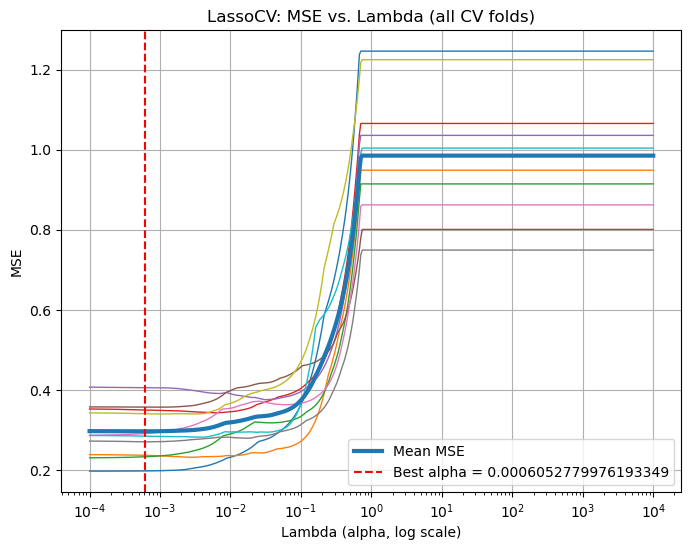

In [125]:
# Plot cross-validation MSE versus lambda for the lasso model

model = lasso.named_steps["model"]

alphas = model.alphas_
mse_path = model.mse_path_

plt.figure(figsize=(8,6))

for i in range(mse_path.shape[1]):
    plt.plot(alphas, mse_path[:, i], linewidth=1)

plt.plot(alphas, mse_path.mean(axis=1), linewidth=3, label='Mean MSE')

plt.axvline(model.alpha_, color='red', linestyle='--', label=f'Best alpha = {model.alpha_}')

plt.xscale('log')
plt.xlabel("Lambda (alpha, log scale)")
plt.ylabel("MSE")
plt.title("LassoCV: MSE vs. Lambda (all CV folds)")
plt.legend()
plt.grid(True)
plt.show()


In [126]:
# Build full feature name list from numeric and one-hot encoded columns
# Build the feature names
num_original = list(num_cols)

# Get OHE names
ohe = lasso.named_steps["prep"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(cat_cols).tolist()

all_features = num_original + cat_feature_names


In [127]:
# Determine which features are kept or dropped by lasso coefficients
coef = lasso.named_steps["model"].coef_

selected_features = [name for name, c in zip(all_features, coef) if c != 0]
selected_features
missing = [f for f in X if f not in selected_features]


In [128]:
# Display features excluded by the lasso regularization
missing

['position',
 'WP',
 'won_cy_young',
 'won_mvp',
 'won_gold_glove',
 'won_silver_slugger',
 'all_star']

The above features were removed by the lasso method, meaning we can remove them from our linear regression model below.

## Linear Regression

In [129]:
# Prepare cleaned dataset, split, and preprocessing for linear regression
batters_clean = batters.dropna(subset=["free_agent_salary"])
X = batters_clean.drop(columns=["row_id", "playerID","year","free_agent_salary","free_agent_salary_log",
                          "ZR","position","WP",'all_star',"contract_length",
                          "won_cy_young","won_mvp","won_gold_glove","won_silver_slugger"])
y = batters_clean["free_agent_salary_log"]

# 2) Train/test split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3) Identify numeric and categorical columns
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# 4) Preprocessing pipeline (impute + OHE + scaling)
num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median"))
])

cat_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_cols),
        ("cat", cat_pipeline, cat_cols)
    ],
    remainder="drop",
    sparse_threshold=0
)

full_pipeline = Pipeline([
    ("pre", preprocessor),
    ("scale", StandardScaler())
])

# 5) Fit pipeline on training data
full_pipeline.fit(X_train_raw)

# 6) Transform train and test sets
X_train_trans = full_pipeline.transform(X_train_raw)
X_test_trans  = full_pipeline.transform(X_test_raw)

# 7) Generate correct feature names
# numeric names
num_names = num_cols
# categorical names from OneHotEncoder

all_feature_names = num_names

# 8) Convert transformed arrays to DataFrames with correct column names
X_train_df = pd.DataFrame(X_train_trans, columns=all_feature_names, index=X_train_raw.index)
X_test_df  = pd.DataFrame(X_test_trans,  columns=all_feature_names, index=X_test_raw.index)

# 9) Fit Linear Regression
lr = LinearRegression()
lr.fit(X_train_df, y_train)

# 10) Predict and evaluate
y_pred = lr.predict(X_test_df)
mse = mean_squared_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)
print(f"Test MSE: {mse:.5f}")
print(f"Test R^2: {r2:.5f}")

# 11) Coefficient DataFrame
coef_df = pd.DataFrame({"feature": all_feature_names, "coefficient": lr.coef_})
print(coef_df.sort_values("coefficient", key=lambda s: s.abs(), ascending=False).head(20))

# 12) Optional: statsmodels OLS summary
X_train_sm = sm.add_constant(X_train_df)
ols_res = sm.OLS(y_train, X_train_sm).fit()
print(ols_res.summary())

Test MSE: 0.34915
Test R^2: 0.65565
            feature  coefficient
4                 H     1.589893
2                AB    -1.336665
7                HR     0.667417
20                A     0.403951
1   avg_salary_year     0.299813
22               DP    -0.295323
19               PO     0.234382
6                3B     0.231805
8               RBI    -0.184131
11               BB     0.157330
12               SO    -0.134232
21                E    -0.109350
5                2B    -0.088806
18          InnOuts     0.087394
13              IBB    -0.064217
3                 R     0.063464
9                SB    -0.059189
0               age    -0.043901
15               SH     0.043854
16               SF    -0.024748
                              OLS Regression Results                             
Dep. Variable:     free_agent_salary_log   R-squared:                       0.713
Model:                               OLS   Adj. R-squared:                  0.696
Method:                  

Looking at out outputs, we see a test R^squared of 0.656, meaning that our model explains about 66% of the variation in each free agent's salary. This indicates that our model does a decent job at predicting free agent salary. Our model's transformed MSE is 0.341, meaning after retransforming, our models are off by a factor of about 1.6. This leads a bit to be desired, but overall isn't terrible at predicting free agent batter's salaries. Overall, our feature directions makes sense, as statistics that are thought of as good, like Home Runs, Hits, and Runs have a positive relationship, and statistics that are thought of as bad, like double plays and strikeouts see a negative relationship. Interestingly, RBIs, a stat that seems like it should have a positive relationship is negative. This may not mean a lot however, as it was deemed insignificant by the model.

## Assumptions

In [130]:
# Calculate residuals and fitted values from the OLS model
residuals = ols_res.resid
fitted = ols_res.fittedvalues

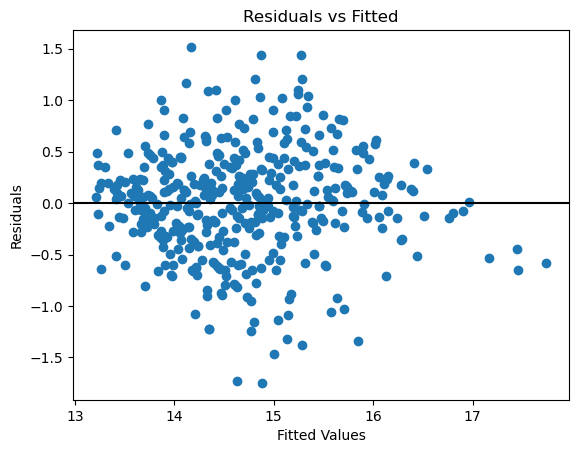

In [131]:
# Plot residuals versus fitted values for diagnostic checks
plt.scatter(fitted, residuals)
plt.axhline(0, color='black')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

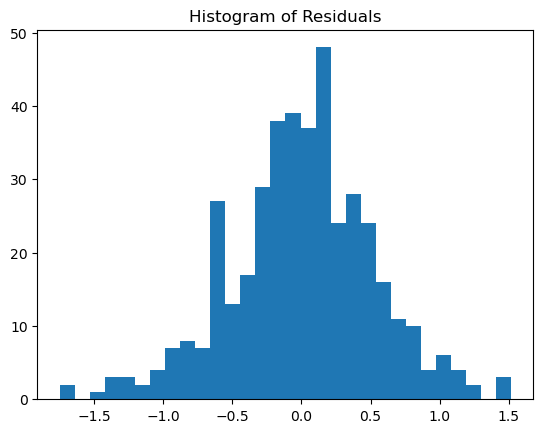

In [132]:
# Plot histogram of residuals to inspect distributional assumptions
plt.hist(residuals, bins=30)
plt.title("Histogram of Residuals")
plt.show()

Looking at our graphs, our assumptions for linear regression appear to pass. I don't see a clear an obvious fanning out, in the residual graphs, and the histogram of residuals appear normal

## Actual vs Predicted

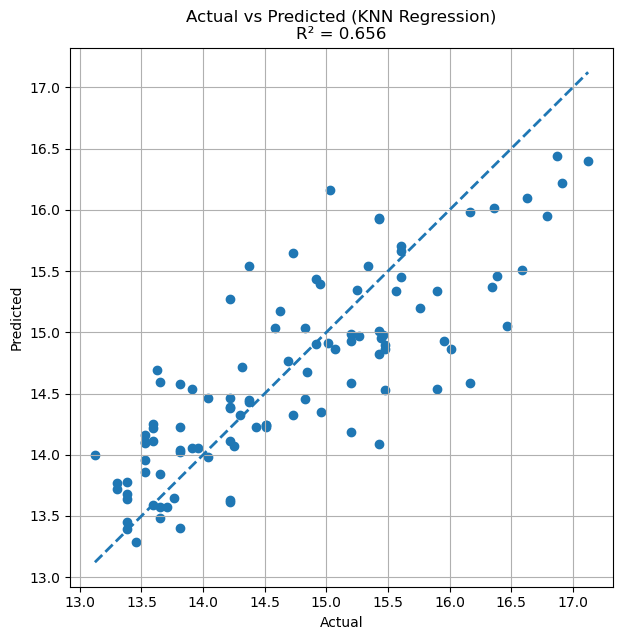

In [133]:
# Visualize actual versus predicted salaries for the linear regression model
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', linewidth=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Actual vs Predicted (KNN Regression)\nR² = {r2:.3f}")
plt.grid(True)
plt.show()